In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import pandas as pd
import seaborn as sns
import datetime

## Опис головних файлів:

train.csv, test.csv - the training and test set of the main dataset. The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.
1. Id: the id of the record
2. Date: date that the WNV test is performed
3. Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
4. Species: the species of mosquitos
5. Block: block number of address
6. Street: street name
7. Trap: Id of the trap
8. AddressNumberAndStreet: approximate address returned from GeoCoder
9. Latitude, Longitude: Latitude and Longitude returned from GeoCoder
10. AddressAccuracy: accuracy returned from GeoCoder
11. NumMosquitos: number of mosquitoes caught in this trap
12. WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.

Одразу можна побачити, що колонки з адресами скоріше варто видалити, залишивши лише довготу і широту. Те саме з Id пастки.
Переглянемо, які фічі є у файлах:

In [2]:
train = pd.read_csv('input/train.csv', parse_dates=['Date'])
test = pd.read_csv('input/test.csv', parse_dates=['Date'])

In [3]:
print(train.dtypes, test.dtypes)

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object Id                                 int64
Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
dtype: object


Видалимо зайві колонки:

In [4]:
features = train.columns.drop(['Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet','AddressAccuracy'])
train = train[features]
test = test[features.drop(['WnvPresent','NumMosquitos'])]

Оглянемо дані:

In [5]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. Згідно з описом даних змагання, записи організовані таким чином, що якщо в одному записі число москітів досягає 50, створюється новий запис. Можна об'єднати дублікати додавши кількість москітів.
2. Для видів москітів застосуємо one-hot encoding.
3. Дані дуже незбалансовані, москітів з вірусом лише 5.2% від усіх.

In [6]:
train = train[train.columns].groupby(list(train.columns.drop('NumMosquitos'))).agg({'NumMosquitos':np.sum}).reset_index()

In [7]:
#one-hot
train = pd.get_dummies(train, columns=['Species'])
test = pd.get_dummies(test, columns=['Species'])

## Погода

In [8]:
weather = pd.read_csv('input/weather.csv', parse_dates=['Date'])

In [9]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                   object
Depart                 object
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall               object
PrecipTotal            object
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

1. Station - дані збиралися з двох станцій, залишимо одну.
2. Depart - відхилення температури від нормальної 30-ти річної температури для цієї дати.
3. DewPoint - точка роси.
4. WetBulb - температура мокрого термометра.
5. Heat, Cool - оцінка підігріву чи охолодження необхідного будівлі.
6. Sunrise, Sunset - схід/захід сонця.
7. CodeSum - коди аномалій (торнадо, урагани і тд.)
8. Depth, Water1, SnowFall - глибина снігу, водний еквівалент(талий сніг), шар свіжого снігу.
9. PrecipTotal - опадів за місяць.
10. StnPressure, SeaLevel - тиск на станції і середній тиск рівня моря.
11. ResultSpeed, ResultDir, AvgSpeed - пікова швидкість, напрям і середня швидкість вітру.


Не схоже, що Heat, Cool, Sunrise, Sunset, Depth, Water1, SnowFall несуть важливу інформацію для завдання, тому їх видалимо.
Із StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed можна залишити по одному показнику: SeaLevel та AvgSpeed

In [10]:
weather.drop(['Tmax', 'Tmin','Heat', 'Cool','Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'StnPressure','ResultSpeed', 'ResultDir'], axis=1, inplace=True)

In [11]:
float_features = {'Tavg','Depart','WetBulb','PrecipTotal','SeaLevel','AvgSpeed'}
for feature in float_features:
    weather[feature] = pd.to_numeric(weather[feature], errors='coerce')
    
weather['Station'] = weather['Station'].astype('category')

In [12]:
ProfileReport(weather)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. У колонках Depart та PrecipTotal багато значень відсутні, приберемо їх.
2. Показники DewPoint та WetBulb сильно корелюють і обидва відповідають за вологість повітря, з них приберемо WetBulb оскільки там є відсутні значення.

In [13]:
weather.drop(['Depart', 'PrecipTotal', 'WetBulb'], axis=1, inplace=True)

In [14]:
weather.isnull().sum()

Station      0
Date         0
Tavg        11
DewPoint     0
SeaLevel     9
AvgSpeed     3
dtype: int64

Перевіримо, з якої станції більше відсутніх даних:

In [15]:
weather_s1 = pd.DataFrame(weather.loc[weather["Station"] == 1])
weather_s2 = pd.DataFrame(weather.loc[weather["Station"] == 2])

print(weather_s1.isnull().sum())
print(weather_s2.isnull().sum())

Station     0
Date        0
Tavg        0
DewPoint    0
SeaLevel    5
AvgSpeed    0
dtype: int64
Station      0
Date         0
Tavg        11
DewPoint     0
SeaLevel     4
AvgSpeed     3
dtype: int64


На першій станції лише кілька відсутніх значень за тиск.
Поглянемо, чи на другій станції немає даних в ті самі дні, чи можна зробити заміну. 

In [16]:
weather_s1[weather_s1.isna()['SeaLevel']].Date

832    2009-06-18
994    2009-09-07
1732   2011-09-08
1756   2011-09-20
2090   2012-09-03
Name: Date, dtype: datetime64[ns]

In [17]:
weather_s2[weather_s2.isna()['SeaLevel']].Date

87     2007-06-13
1745   2011-09-14
2067   2012-08-22
2743   2014-07-23
Name: Date, dtype: datetime64[ns]

Можна замінити:

In [18]:
weather_s1.set_index('Date', inplace=True)
weather_s2.set_index('Date', inplace=True)
weather_s1=weather_s1.fillna(weather_s2)
print(weather_s1.isnull().sum())

Station     0
Tavg        0
DewPoint    0
SeaLevel    0
AvgSpeed    0
dtype: int64


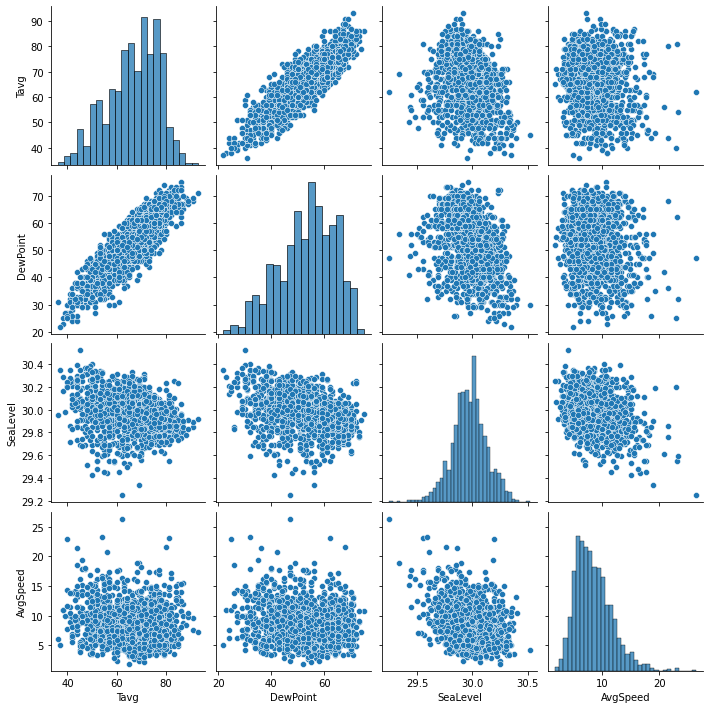

In [19]:
weather_s1.drop(['Station'], axis=1, inplace=True)
weather_s1.reset_index()
sns.pairplot(weather_s1)

### Додаємо weather i train

Додамо більш усереднені значення за тиждень

In [20]:
def weather_add(df, weather_col, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather_s1.index <= i) & (weather_s1.index >= i - pd.Timedelta(days=days_range))
        data_list = np.mean(weather_s1[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [21]:
for col in weather_s1.columns:
    train[col] = weather_add(train, weather_col=col)

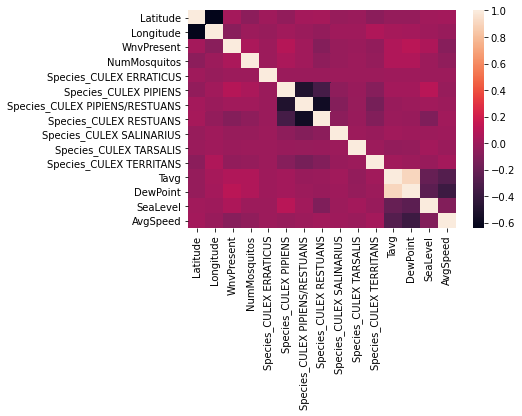

In [22]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix)
plt.show()

### Додамо ознаки з datetime

День закодуємо кількістю днів з початку року

In [23]:
train['year']  = train['Date'].dt.year
train['day'] = train['Date'].apply(lambda x: x.toordinal()-datetime.date(x.year, 1, 1).toordinal())

Видалимо зайві фічі:

In [24]:
features = train.columns.drop(['WnvPresent','Date'])

X = train[features]
y = train.WnvPresent

# Підбір моделей

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score



random_state = 42
np.random.seed(random_state)

In [26]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)
results = dict()

In [27]:
def clf_score(model, name, x_train, x_val, y_train, y_val):
    model.fit(x_train, y_train) 
    print('train score', roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    print('val score', roc_auc_score(y_val, model.predict_proba(x_val)[:, 1]))
    results[name] = {'train': roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]), 'val': roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])}

### LogisticRegression

In [28]:
log_reg_clf = LogisticRegression(max_iter=1000)
clf_score(log_reg_clf, 'log_reg_clf', x_train, x_val, y_train, y_val)

train score 0.7599287417908479
val score 0.7468193921974724


### RandomForestClassifier

In [29]:
#rand_for_clf = GridSearchCV(RandomForestClassifier(random_state=random_state), {'n_estimators': [450, 500, 550]}, scoring='roc_auc')
#rand_for_clf.fit(x_train, y_train)
#print(rand_for_clf.best_params_)

rand_for_clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
clf_score(rand_for_clf, 'rand_for_clf', x_train, x_val, y_train, y_val)

train score 0.999999316402445
val score 0.8394057229806839


In [30]:
f_i=dict(zip(x_train.columns, rand_for_clf.feature_importances_))
pd.DataFrame.from_dict(f_i,orient='index',columns=['importances']).sort_values(['importances'],ascending=False)

importances
NumMosquitos                       0.293499
Longitude                          0.201576
Latitude                           0.193227
day                                0.062721
Tavg                               0.044101
DewPoint                           0.042773
SeaLevel                           0.041788
AvgSpeed                           0.039765
Species_CULEX PIPIENS              0.024932
Species_CULEX PIPIENS/RESTUANS     0.022021
year                               0.019174
Species_CULEX RESTUANS             0.013424
Species_CULEX TERRITANS            0.000620
Species_CULEX SALINARIUS           0.000328
Species_CULEX ERRATICUS            0.000038
Species_CULEX TARSALIS             0.000013

Найбільшу вагу має NumMosquitos, проте цієї фічі немає у тестовому наборі.
В мене виникла ідея створити предіктор для заповнення NumMosquitos у тестових даних і подивитися, 
як працюють різні моделі з колонкою NumMosquitos і без неї та зі штучною NumMosquitos. Нижче порівнюються різні моделі із оригінальною NumMosquitos з валідаційного набору.

### AdaBoostClassifier

In [31]:
ada_boost_clf= AdaBoostClassifier()
clf_score(ada_boost_clf, 'ada_boost_clf', x_train, x_val, y_train, y_val)

train score 0.9132412162841141
val score 0.8770235428378208


### GradientBoostingClassifier

In [32]:
#grad_boost_clf = GridSearchCV(GradientBoostingClassifier(random_state=random_state), {'n_estimators': [100, 150, 200, 250], 'learning_rate': np.linspace(0.00001, 0.0001, 3)}, scoring='roc_auc')
#grad_boost_clf.fit(x_train, y_train)
#print(grad_boost_clf.best_params_)

grad_boost_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=random_state)
clf_score(grad_boost_clf, 'grad_boost_clf', x_train, x_val, y_train, y_val)


train score 0.9517009274368031
val score 0.8828352846696818


### XGBClassifier

In [33]:
xg_boost_clf = XGBClassifier(objective='binary:logistic', eval_metric='auc',use_label_encoder=False) 
clf_score(xg_boost_clf, 'xg_boost_clf', x_train, x_val, y_train, y_val)

train score 0.9994479949741908
val score 0.8512616763176803


### Результати

In [34]:
pd.DataFrame.from_dict(results).T.sort_values(['val'],ascending=False)

train       val
grad_boost_clf  0.951701  0.882835
ada_boost_clf   0.913241  0.877024
xg_boost_clf    0.999448  0.851262
rand_for_clf    0.999999  0.839406
log_reg_clf     0.759929  0.746819

## Те саме на даних взагалі без NumMosquitos

In [35]:
features = features.drop(['NumMosquitos'])

X = train[features]
y = train.WnvPresent

In [36]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [37]:
clf_score(log_reg_clf, 'log_reg_clf2', x_train, x_val, y_train, y_val)
clf_score(rand_for_clf, 'rand_for_clf2', x_train, x_val, y_train, y_val)
clf_score(ada_boost_clf, 'ada_boost_clf2', x_train, x_val, y_train, y_val)
clf_score(grad_boost_clf, 'grad_boost_clf2', x_train, x_val, y_train, y_val)
clf_score(xg_boost_clf, 'xg_boost_clf2', x_train, x_val, y_train, y_val)

f_i=dict(zip(x_train.columns, rand_for_clf.feature_importances_))
pd.DataFrame.from_dict(f_i,orient='index',columns=['importances']).sort_values(['importances'],ascending=False)

train score 0.7563142197178246
val score 0.7416944925821041
train score 0.9980066295290901
val score 0.7904285895430915
train score 0.8723827613102924
val score 0.8271693647237838
train score 0.9306375777677669
val score 0.8445834566127055
train score 0.9928160732925955
val score 0.8148167716302465


importances
Longitude                          0.355550
Latitude                           0.344358
day                                0.052349
DewPoint                           0.040989
Tavg                               0.040279
SeaLevel                           0.036868
AvgSpeed                           0.035229
Species_CULEX PIPIENS              0.026081
Species_CULEX PIPIENS/RESTUANS     0.024913
year                               0.022537
Species_CULEX RESTUANS             0.017114
Species_CULEX TERRITANS            0.002234
Species_CULEX SALINARIUS           0.001142
Species_CULEX ERRATICUS            0.000334
Species_CULEX TARSALIS             0.000023

In [38]:
pd.DataFrame.from_dict(results).T.sort_values(['val'],ascending=False)

train       val
grad_boost_clf   0.951701  0.882835
ada_boost_clf    0.913241  0.877024
xg_boost_clf     0.999448  0.851262
grad_boost_clf2  0.930638  0.844583
rand_for_clf     0.999999  0.839406
ada_boost_clf2   0.872383  0.827169
xg_boost_clf2    0.992816  0.814817
rand_for_clf2    0.998007  0.790429
log_reg_clf      0.759929  0.746819
log_reg_clf2     0.756314  0.741694

## Побудова предіктору

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error

In [40]:
X = train[features]
y = train.NumMosquitos

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [41]:
results_reg = dict()

In [42]:
def score(model,name, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    results_reg[name] = {'train MSE\t': mean_squared_error(y_train, model.predict(x_train)), 'val   MSE\t': mean_squared_error(y_val, model.predict(x_val)),'train MAE\t': median_absolute_error(y_train, model.predict(x_train)),'val   MAE\t': median_absolute_error(y_val, model.predict(x_val))}
    for key, value in results_reg[name].items():
        print(key, value)

### LinearRegression

In [43]:
lin_reg = LinearRegression()
score(lin_reg,'lin_reg', x_train, y_train, x_val, y_val)

train MSE	 4915.789645351815
val   MSE	 1836.7601837491695
train MAE	 11.650116124579199
val   MAE	 12.135716642741386


### RandomForestRegressor

In [44]:
#rand_for_reg = GridSearchCV(RandomForestRegressor(random_state=random_state), {'n_estimators': [100,150,200,250]}, scoring='neg_mean_squared_error')
#rand_for_reg.fit(x_train, y_train)
#print(rand_for_reg.best_params_)

rand_for_reg = RandomForestRegressor(n_estimators=100, random_state=random_state)
score(rand_for_reg,'rand_for_reg', x_train, y_train, x_val, y_val)


train MSE	 1507.5557306129028
val   MSE	 2374.0230355306667
train MAE	 1.6899999999999995
val   MAE	 4.29


In [45]:
f_i=dict(zip(x_train.columns, rand_for_reg.feature_importances_))
pd.DataFrame.from_dict(f_i,orient='index',columns=['importances']).sort_values(['importances'],ascending=False)

importances
Latitude                        1.939269e-01
Species_CULEX PIPIENS           1.221540e-01
day                             1.211678e-01
AvgSpeed                        1.027752e-01
Longitude                       8.456658e-02
year                            8.429108e-02
DewPoint                        8.159825e-02
SeaLevel                        7.506822e-02
Tavg                            7.076322e-02
Species_CULEX PIPIENS/RESTUANS  4.688993e-02
Species_CULEX RESTUANS          1.161459e-02
Species_CULEX TERRITANS         3.514950e-03
Species_CULEX SALINARIUS        1.618469e-03
Species_CULEX ERRATICUS         5.044379e-05
Species_CULEX TARSALIS          3.628879e-07

### AdaBoostRegressor

In [46]:
#adaboost_reg = GridSearchCV(AdaBoostRegressor(random_state=random_state), {'n_estimators': [30,40,50]}, scoring='neg_mean_squared_error')
#adaboost_reg.fit(x_train, y_train)
#print(adaboost_reg.best_params_)

adaboost_reg= AdaBoostRegressor(n_estimators=30, random_state=random_state)
score(adaboost_reg,'adaboost_reg', x_train, y_train, x_val, y_val)

train MSE	 3025.005137319692
val   MSE	 2764.476895460607
train MAE	 9.075606034921172
val   MAE	 9.075606034921172


### GradientBoostingRegressor

In [47]:
#grad_boost_reg = GridSearchCV(GradientBoostingRegressor(random_state=random_state), {'n_estimators': [100,150,200,250]}, scoring='neg_mean_squared_error')
#grad_boost_reg.fit(x_train, y_train)
#print(grad_boost_reg.best_params_)

grad_boost_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)
score(grad_boost_reg,'grad_boost_reg', x_train, y_train, x_val, y_val)

train MSE	 2967.495508887237
val   MSE	 2056.1150783552594
train MAE	 6.237147182638376
val   MAE	 6.412603155701641


### XGBRegressor

In [48]:
from xgboost.sklearn import XGBRegressor

In [49]:
xg_boost_reg = XGBRegressor() 
score(xg_boost_reg,'xg_boost_reg', x_train, y_train, x_val, y_val)

train MSE	 1474.0012473883062
val   MSE	 2408.3871644205205
train MAE	 3.7785587310791016
val   MAE	 5.110632419586182


### Results

In [50]:
pd.DataFrame.from_dict(results_reg).T.sort_values(['val   MSE\t'],ascending=True)

train MSE\t  val   MSE\t  train MAE\t  val   MAE\t
lin_reg         4915.789645  1836.760184    11.650116    12.135717
grad_boost_reg  2967.495509  2056.115078     6.237147     6.412603
rand_for_reg    1507.555731  2374.023036     1.690000     4.290000
xg_boost_reg    1474.001247  2408.387164     3.778559     5.110632
adaboost_reg    3025.005137  2764.476895     9.075606     9.075606

На перший погляд лінійна регрессія краще впоралась з відхиленнями на валідаційному датасеті. Проте на тренувальному датасеті показник найгірший,
тож скоріш за все моделі просто пощастило з даними валідаційного датасету. 
Перевіримо точність класифікаторів на валідаційному датасеті із передбаченнями від моделей grad_boost_reg, rand_for_reg, xg_boost_reg.	

## Моделі із згенерованими фічами

In [51]:
features = train.columns.drop(['WnvPresent','Date'])

X = train[features]
y = train.WnvPresent

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)
x_val = pd.DataFrame(x_val.copy())

### GradientBoostingRegressor + RandomForest, AdaBoost, GradientBoosting, XGB classifiers

In [52]:
x_val['NumMosquitos'] = grad_boost_reg.predict(x_val.drop('NumMosquitos', axis=1))

clf_score(rand_for_clf, 'rfc+gbr', x_train, x_val, y_train, y_val)
clf_score(ada_boost_clf, 'abc+gbr', x_train, x_val, y_train, y_val)
clf_score(grad_boost_clf, 'gbc+gbr', x_train, x_val, y_train, y_val)
clf_score(xg_boost_clf, 'xgbc+gbr', x_train, x_val, y_train, y_val)

train score 0.999999316402445
val score 0.7862652690308127
train score 0.9132412162841141
val score 0.819624667145695
train score 0.9517009274368031
val score 0.8114353945644364
train score 0.9994479949741908
val score 0.8033623568198148


### RandomForestRegressor + RandomForest, AdaBoost, GradientBoosting, XGB classifiers

In [53]:
x_val['NumMosquitos'] = rand_for_reg.predict(x_val.drop('NumMosquitos', axis=1))

clf_score(rand_for_clf, 'rfc+rfr', x_train, x_val, y_train, y_val)
clf_score(ada_boost_clf, 'abc+rfr', x_train, x_val, y_train, y_val)
clf_score(grad_boost_clf, 'gbc+rfr', x_train, x_val, y_train, y_val)
clf_score(xg_boost_clf, 'xgbc+rfr', x_train, x_val, y_train, y_val)

train score 0.999999316402445
val score 0.770541865674796
train score 0.9132412162841141
val score 0.8276660044803247
train score 0.9517009274368031
val score 0.8182192823027178
train score 0.9994479949741908
val score 0.7872796821505558


### XGBRegressor + RandomForest, AdaBoost, GradientBoosting, XGB classifiers

In [54]:
x_val['NumMosquitos'] = xg_boost_reg.predict(x_val.drop('NumMosquitos', axis=1))

clf_score(rand_for_clf, 'rfc+xgbr', x_train, x_val, y_train, y_val)
clf_score(ada_boost_clf, 'abc+xgbr', x_train, x_val, y_train, y_val)
clf_score(grad_boost_clf, 'gbc+xgbr', x_train, x_val, y_train, y_val)
clf_score(xg_boost_clf, 'xgbc+xgbr', x_train, x_val, y_train, y_val)

train score 0.999999316402445
val score 0.7955746227651211
train score 0.9132412162841141
val score 0.8341962889386701
train score 0.9517009274368031
val score 0.820396043788833
train score 0.9994479949741908
val score 0.807758147005368


In [55]:
pd.DataFrame.from_dict(results).T.sort_values(['val'],ascending=False)

train       val
grad_boost_clf   0.951701  0.882835
ada_boost_clf    0.913241  0.877024
xg_boost_clf     0.999448  0.851262
grad_boost_clf2  0.930638  0.844583
rand_for_clf     0.999999  0.839406
abc+xgbr         0.913241  0.834196
abc+rfr          0.913241  0.827666
ada_boost_clf2   0.872383  0.827169
gbc+xgbr         0.951701  0.820396
abc+gbr          0.913241  0.819625
gbc+rfr          0.951701  0.818219
xg_boost_clf2    0.992816  0.814817
gbc+gbr          0.951701  0.811435
xgbc+xgbr        0.999448  0.807758
xgbc+gbr         0.999448  0.803362
rfc+xgbr         0.999999  0.795575
rand_for_clf2    0.998007  0.790429
xgbc+rfr         0.999448  0.787280
rfc+gbr          0.999999  0.786265
rfc+rfr          0.999999  0.770542
log_reg_clf      0.759929  0.746819
log_reg_clf2     0.756314  0.741694

# Підготовка тестових даних

In [63]:
for col in weather_s1.columns:
    test[col] = weather_add(test, weather_col=col)

In [65]:
test['year']  = test['Date'].dt.year
test['day'] = test['Date'].apply(lambda x: x.toordinal()-datetime.date(x.year, 1, 1).toordinal())

In [71]:
test_X = test.drop(['Date', 'Species_UNSPECIFIED CULEX'], axis=1)

## submissions

In [83]:
x_train_n = train[features]
x_train = train[features.drop('NumMosquitos')]
y_train = train.WnvPresent
test_x_n = pd.DataFrame(test_X.copy())
test_x_n.insert(2, 'NumMosquitos', 0)

In [78]:
def build_submission(model, name, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    predictions = model.predict_proba(x_test)[:, 1]
    res_df = pd.DataFrame({'Id': np.arange(1, len(predictions)+1, 1), 'WnvPresent': predictions})
    location = './working/{}.csv'.format(name)
    res_df.to_csv(location, index=False)

In [85]:
#grad_boost_clf2
#Private Score 0.70268
#Public Score 0.71922
build_submission(grad_boost_clf, 'grad_boost_clf2', x_train, y_train, test_X) 

#abc+xgbr
#Private Score 0.70593
#Public Score 0.72440
test_x_n['NumMosquitos'] = xg_boost_reg.predict(test_x_n.drop('NumMosquitos', axis=1))
build_submission(ada_boost_clf, 'abc_xgbr', x_train_n, y_train, test_x_n) 

#abc+rfr
#Private Score 0.69556
#Public Score 0.72216
test_x_n['NumMosquitos'] =  rand_for_reg.predict(test_x_n.drop('NumMosquitos', axis=1))
build_submission(ada_boost_clf, 'abc_rfr', x_train_n, y_train, test_x_n) 

#ada_boost_clf2
#Private Score 0.69902
#Public Score 0.72129
build_submission(ada_boost_clf, 'ada_boost_clf2', x_train, y_train, test_X)


#gbc+xgbr
#Private Score 0.71529
#Public Score 0.71320
test_x_n['NumMosquitos'] = xg_boost_reg.predict(test_x_n.drop('NumMosquitos', axis=1))
build_submission(grad_boost_clf, 'gbc_xgbr', x_train_n, y_train, test_x_n) 